### Source code for generating the tables and plots in the article

In [1]:
import pandas as pd
import numpy as np
import os 
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cwd=os.getcwd()

### current fleet

In [3]:
# load generation info from NEM factsheet
# energy data from 1 July 2022 to 30 June 2023
raw_data_dir=os.path.abspath(os.path.join(cwd, '../raw_data'))
df_gen_info=pd.read_csv(raw_data_dir+'/2023_gen_info.csv', skiprows=[0], index_col=0)
# rename wind to onshore; add CCS to gas and coal to match with gen cost data labels
df_gen_info=df_gen_info.rename({'coal':'coalCCS', 'gas':'gasCCS', 'wind':'onshore'})
# add lifespan column; assume 25 years except for battery (10 years) and hydro (90 years)
df_gen_info['lifetime']=25
df_gen_info.loc[df_gen_info.index=='battery', 'lifetime']=10
df_gen_info.loc[df_gen_info.index=='hydro', 'lifetime']=90
# attribute all of the 0.24% summed over the last three technologies to biomass and delete other
df_gen_info.loc[df_gen_info.index=='battery', 'supply_mix_pc']=0
df_gen_info=df_gen_info.drop(['other']) # remove 'other' technologies
df_gen_info=df_gen_info.drop(['note'], axis=1) # remove 'note' column
# divide supply_mic_pc column by 100 to get factor and rename
df_gen_info['supply_mix_pc']=df_gen_info['supply_mix_pc']/100
df_gen_info=df_gen_info.rename({'supply_mix_pc':'energy_share'}, axis=1)


df_gen_info

,capacity_MW_Oct23,energy_share,lifetime
fuel,,,
coalCCS,21255,0.5760,25
rooftop solar,18000,0.0996,25
gasCCS,11924,0.0549,25
onshore,10582,0.1295,25
grid solar,8652,0.0615,25
hydro,7999,0.0762,90
battery,1413,0.0000,10
biomass,542,0.0024,25


In [4]:
# check sum of shares
df_gen_info['energy_share'].sum()

1.0001000000000002

In [5]:
# change shares of biomass so they sum to exactly 1
df_gen_info.loc['biomass', 'energy_share']+=(1-df_gen_info['energy_share'].sum())
df_gen_info

,capacity_MW_Oct23,energy_share,lifetime
fuel,,,
coalCCS,21255,0.5760,25
rooftop solar,18000,0.0996,25
gasCCS,11924,0.0549,25
onshore,10582,0.1295,25
grid solar,8652,0.0615,25
hydro,7999,0.0762,90
battery,1413,0.0000,10
biomass,542,0.0023,25


In [6]:
# load gen cost data 

df_gen_cost=pd.read_csv(raw_data_dir+'/gencost_2223_summary.csv', skiprows=[0], index_col=0)
df_gen_cost

,CAP [AUD/kW],fixed O&M [AUD/kW/yr],variable O&M [AUD/MWh],CO2 store [AUD/MWh],fuel [AUD/MWh]
technology,,,,,
onshore,1642,25.00,0.00,0.00,0.000000
solar,498,17.00,0.00,0.00,0.000000
gasCCS,3012,16.35,7.20,1.90,106.568182
coalCCS,8083,77.80,7.95,4.13,34.600000
rooftop solar,483,17.00,0.00,0.00,0.000000
grid solar,513,17.00,0.00,0.00,0.000000
biomass,7292,131.60,8.40,0.00,0.000000
hydro,5500,100.00,0.00,0.00,0.000000


In [7]:
# load demand data; need only from 1 July 2022 to 30 June 2023

NEMWEB_data_dir=os.path.abspath(os.path.join(cwd, '../raw_data/demand'))
df_demand_raw=pd.read_csv(NEMWEB_data_dir+'/AGGdemand_99to23.csv')

df_demand_raw['AEST']=pd.to_datetime(df_demand_raw['AEST'])
df_demand_raw=df_demand_raw.set_index('AEST')

# for demand for financial year 22-23
s_demand23=df_demand_raw.loc[(df_demand_raw.index>=pd.to_datetime('2022-07-01 00:00:00')) &
                               (df_demand_raw.index<=pd.to_datetime('2023-06-30 23:00:00'))].sum(axis=1)
s_demand23.describe()

count     8760.000000
mean     20816.376444
std       3250.876856
min      11782.206667
25%      18477.772917
50%      20371.938750
75%      22841.330833
max      32141.209167
dtype: float64

In [8]:
# find peak demand [MW]

peak_demand23=s_demand23.max()

print(s_demand23.nlargest())

AEST
2023-06-20 18:00:00    32141.209167
2023-06-21 18:00:00    32048.406667
2023-06-22 18:00:00    31510.728333
2022-07-19 18:00:00    31451.266667
2023-06-21 17:00:00    31397.700833
dtype: float64


In [9]:
df_gen_info.loc[['grid solar', 'rooftop solar'], 'capacity_MW_Oct23'].sum()/peak_demand23

0.8292158475369535

In [10]:
# total annual **operational** demand [MWh]; time series does not include behind the meter rooftop PV
annual_op_demand23=s_demand23.sum()

# use energy_shares minus PV to find total demand
annual_demand23=annual_op_demand23/(1-df_gen_info.loc['rooftop solar', 'energy_share'])

print(annual_op_demand23, annual_demand23)

182351457.6475 202522720.62139052


In [11]:
# compute gen cost for 2023

# initialise cost sum loop
gencost=0

# battery is not a generation technology

gen_techs23=[tech for tech in df_gen_info.index if tech != 'battery']

for tech in gen_techs23:
    # installed capacity [MW]
    IC=df_gen_info.loc[tech, 'capacity_MW_Oct23']
    # unit_CAPEX; convert to [$/MW/year]
    annual_unit_cap=df_gen_cost.loc[tech, 'CAP [AUD/kW]']*1000/df_gen_info.loc[tech, 'lifetime'] 
    annual_CAPEX=IC*annual_unit_cap
    
    # fixed O&M, convert to [$/MW/year]
    annual_fOM=df_gen_cost.loc[tech, 'fixed O&M [AUD/kW/yr]']*1000
    
    # variable costs, in $/year
    var_per_MWh=df_gen_cost.loc[tech, ['variable O&M [AUD/MWh]','CO2 store [AUD/MWh]','fuel [AUD/MWh]']].sum()
    annual_MWh=df_gen_info.loc[tech, 'energy_share']*annual_demand23
    annual_VAR=var_per_MWh*annual_MWh
    
    # sum all
    
    total_tech_annual_cost=annual_CAPEX+annual_fOM+annual_VAR
       
    # total over all techs
    
    gencost+=total_tech_annual_cost

    print(tech, total_tech_annual_cost)

# add back battery cost, assume 4-hour battery 
annual_battery_cost=162000*4*df_gen_info.loc['battery', 'capacity_MW_Oct23']/ \
                    df_gen_info.loc['battery', 'lifetime']

total_annual_cost23=gencost+annual_battery_cost

print('total supply cost =', total_annual_cost23)

coalCCS 12317610504.79735
rooftop solar 347777000.0
gasCCS 2722676244.426018
onshore 695050760.0
grid solar 177556040.0
hydro 488927777.7777778
biomass 162134898.9624049
total supply cost = 17003295625.96355


In [12]:
# cost in $/MWh
cost23_AUDpMWh=total_annual_cost23/annual_demand23

# cost in $/year/MW of peak load
cost23_AUDpMWpeak=total_annual_cost23/peak_demand23

print(cost23_AUDpMWh, ' $/MWh')
print(cost23_AUDpMWpeak, ' $/year/MW of peak load')

83.95747190139049  $/MWh
529018.5424510258  $/year/MW of peak load


In [13]:
# VRE data
file_VRE = open('../preprocessing/df_VRE.pkl', 'rb')

df_VRE = pickle.load(file_VRE)

file_VRE.close()

df_VRE.describe()


,NSA_wind,ADE_wind,SESA_wind,NQ_wind,CQ_wind,SWQ_wind,SEQ_wind,NNS_wind,NCEN_wind,SWNSW_wind,...,SEQ_pv,NNS_pv,NCEN_pv,SWNSW_pv,CAN_pv,CVIC_pv,NVIC_pv,MEL_pv,LV_pv,TAS_pv
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,...,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,0.487176,0.518950,0.482749,0.412358,0.399124,0.371925,0.298820,0.369941,0.410580,0.430320,...,0.223738,0.230826,0.224122,0.227533,0.221578,0.220851,0.213939,0.200579,0.191443,0.184123
std,0.250937,0.311564,0.294525,0.186893,0.209994,0.216614,0.232979,0.229998,0.264962,0.256515,...,0.292910,0.300694,0.294765,0.299780,0.302242,0.298624,0.293695,0.280950,0.271458,0.273811
min,0.000170,0.000000,0.000000,0.003431,0.000033,0.000023,0.000000,0.000073,0.000015,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283203,0.239799,0.226274,0.268482,0.233753,0.195482,0.115597,0.175866,0.176217,0.215271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487286,0.532403,0.470042,0.412669,0.403292,0.361328,0.243690,0.352348,0.392946,0.422647,...,0.003167,0.004674,0.003822,0.004537,0.001356,0.001878,0.001367,0.001156,0.000933,0.000000
75%,0.689897,0.805126,0.736311,0.553285,0.558590,0.530006,0.435457,0.540617,0.625332,0.633184,...,0.476179,0.497844,0.476866,0.475440,0.440186,0.460181,0.428022,0.382439,0.353978,0.318978
max,0.990404,0.991690,0.991685,0.966683,0.980837,0.986573,0.991660,0.991663,0.991540,0.991620,...,0.921856,0.952050,0.945950,0.952181,0.986578,0.948800,0.957956,0.967111,0.982356,1.000000


In [14]:
df_VRE.describe()

,NSA_wind,ADE_wind,SESA_wind,NQ_wind,CQ_wind,SWQ_wind,SEQ_wind,NNS_wind,NCEN_wind,SWNSW_wind,...,SEQ_pv,NNS_pv,NCEN_pv,SWNSW_pv,CAN_pv,CVIC_pv,NVIC_pv,MEL_pv,LV_pv,TAS_pv
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,...,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,0.487176,0.518950,0.482749,0.412358,0.399124,0.371925,0.298820,0.369941,0.410580,0.430320,...,0.223738,0.230826,0.224122,0.227533,0.221578,0.220851,0.213939,0.200579,0.191443,0.184123
std,0.250937,0.311564,0.294525,0.186893,0.209994,0.216614,0.232979,0.229998,0.264962,0.256515,...,0.292910,0.300694,0.294765,0.299780,0.302242,0.298624,0.293695,0.280950,0.271458,0.273811
min,0.000170,0.000000,0.000000,0.003431,0.000033,0.000023,0.000000,0.000073,0.000015,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283203,0.239799,0.226274,0.268482,0.233753,0.195482,0.115597,0.175866,0.176217,0.215271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487286,0.532403,0.470042,0.412669,0.403292,0.361328,0.243690,0.352348,0.392946,0.422647,...,0.003167,0.004674,0.003822,0.004537,0.001356,0.001878,0.001367,0.001156,0.000933,0.000000
75%,0.689897,0.805126,0.736311,0.553285,0.558590,0.530006,0.435457,0.540617,0.625332,0.633184,...,0.476179,0.497844,0.476866,0.475440,0.440186,0.460181,0.428022,0.382439,0.353978,0.318978
max,0.990404,0.991690,0.991685,0.966683,0.980837,0.986573,0.991660,0.991663,0.991540,0.991620,...,0.921856,0.952050,0.945950,0.952181,0.986578,0.948800,0.957956,0.967111,0.982356,1.000000


In [15]:
# demand factor

file_d = open('../preprocessing/s_demand.pkl', 'rb')

s_demand = pickle.load(file_d)

file_d.close()

s_demand.describe()



count    87672.000000
mean         0.672161
std          0.092507
min          0.423928
25%          0.601167
50%          0.677592
75%          0.741519
max          1.000000
Name: NEM, dtype: float64

In [16]:
# bootstrap selections
file_bs = open('../model/copperplate/M_bootstrap.pkl', 'rb')

M_bootstrap = pickle.load(file_bs)

file_bs.close()

bs54=M_bootstrap[54]

s_demand54=s_demand.iloc[bs54]



In [17]:
# mean annual demand from bootstrap sample
annual_demand_bs54=s_demand54.sum()/2 # divide by 2 because samples are 2 years long 

# mean annual demand based on 10 years of data
annual_demand_10y=s_demand.sum()/10
# compare
print(annual_demand_10y, annual_demand_bs54)

5892.971374148377 5890.0093185013675


In [18]:
s_demand.describe()

count    87672.000000
mean         0.672161
std          0.092507
min          0.423928
25%          0.601167
50%          0.677592
75%          0.741519
max          1.000000
Name: NEM, dtype: float64

In [19]:
# compare std of wind, solar and demand
s_VRE_std=df_VRE.std()
print('mean std of wind =', s_VRE_std[:16].mean())
print('mean std of solar =', s_VRE_std[16:].mean())
print('mean std of demand =', s_demand.std())


mean std of wind = 0.2591409103897439
mean std of solar = 0.29282384897028335
mean std of demand = 0.09250707091412777


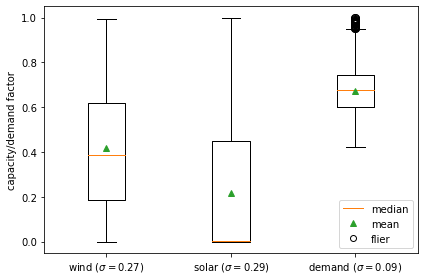

In [20]:
from matplotlib.lines import Line2D
box_plot_data=[df_VRE.iloc[:, :16].values.ravel(),df_VRE.iloc[:, 16:].values.ravel(),  s_demand.values]

plt.boxplot(box_plot_data, showfliers=True, showmeans=True, #whis=[0.05,99.95],
           labels=[r'wind (${\sigma}=%.2f$)' %box_plot_data[0].std(), # %s_VRE_std[:16].mean()
                   r'solar (${\sigma}=%.2f$)' %box_plot_data[1].std(), #%s_VRE_std[16:].mean()
                   'demand ($\sigma=%.2f$)' %box_plot_data[2].std()],
           flierprops={'marker': 'o', 'markersize': 8})

plt.ylabel('capacity/demand factor')


# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend
line = Line2D([0], [0], label='median', color='tab:orange', lw=1)
point = Line2D([0], [0], label='mean', marker='^', 
         markeredgecolor='tab:green', markerfacecolor='tab:green', linestyle='')
circle= Line2D([0], [0], label='flier', marker='o', 
         markeredgecolor='k',markerfacecolor='white', linestyle='')
# add manual symbols to auto legend
handles.extend([line, point, circle])

plt.legend(handles=handles)

plt.tight_layout()

plt.savefig('boxplot_VREvsdemand.png', dpi=300)
plt.show()



### copperplate

In [21]:
# copperplate efficient frontiers
file = open('../model/copperplate/result_bootstrap_vard.pkl', 'rb')

EF = pickle.load(file)

file.close()

In [22]:
# representative case is 54
df_cp=EF[54]
df_cp[df_cp<0.000001]=0
df_cp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_wind,0.346978,0.312872,0.305196,0.291913,0.290134,0.283382,0.272011,0.253027,0.241697,0.230532,0.223554,0.207062,0.193056,0.180414,0.168269,0.143834,0.121521,0.086743
ADE_wind,0.000000,0.004486,0.009109,0.014823,0.017462,0.011146,0.008709,0.006115,0.002938,0.002311,0.000090,0.000000,0.000000,0.000000,0.000438,0.002869,0.004672,0.000000
SESA_wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NQ_wind,0.657934,0.653648,0.642855,0.627197,0.612891,0.572751,0.544880,0.508859,0.481421,0.459537,0.442498,0.416230,0.392752,0.370094,0.348999,0.310465,0.271311,0.242620
CQ_wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.030576,0.047718,0.058994,0.062899,0.060369,0.057510,0.049635,0.043552,0.043451,0.043167,0.041349,0.041732,0.031333
SWQ_wind,0.087874,0.103902,0.120657,0.141427,0.165647,0.171047,0.166909,0.162348,0.157619,0.159471,0.159378,0.159871,0.158999,0.152498,0.145823,0.133794,0.121472,0.128640
SEQ_wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035027
NNS_wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NCEN_wind,0.145447,0.156369,0.153833,0.152291,0.145436,0.127828,0.115106,0.098808,0.088944,0.080327,0.071462,0.056710,0.044653,0.039167,0.034800,0.025873,0.018673,0.000000
SWNSW_wind,0.028195,0.017434,0.022504,0.026146,0.014177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


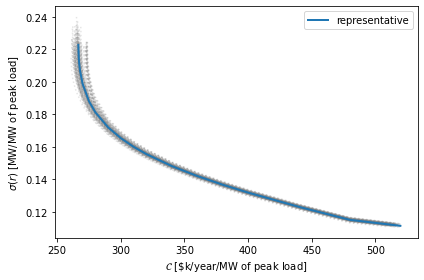

In [23]:
# plot efficient frontier

for bs in range(100):

    plt.plot(EF[bs].iloc[-2]/1000, np.sqrt(EF[bs].iloc[-1]), linestyle=':', color='grey', alpha=0.2)
    
plt.plot(df_cp.iloc[-2]/1000, np.sqrt(df_cp.iloc[-1]), lw=2, label='representative')
    
plt.xlabel(r"$\mathcal{C} $" +" [\$k/year/MW of peak load]")
plt.ylabel('$\sigma(r)$ [MW/MW of peak load]')

plt.legend()
plt.tight_layout()

#plt.savefig('EF.png', dpi=300)

plt.show()

In [24]:
# demand factor

file_d = open('../preprocessing/s_demand.pkl', 'rb')

s_demand = pickle.load(file_d)

file_d.close()

s_demand.describe()

count    87672.000000
mean         0.672161
std          0.092507
min          0.423928
25%          0.601167
50%          0.677592
75%          0.741519
max          1.000000
Name: NEM, dtype: float64

In [25]:
# bootstrap selections
file_bs = open('../model/copperplate/M_bootstrap.pkl', 'rb')

M_bootstrap = pickle.load(file_bs)

file_bs.close()

bs54=M_bootstrap[54]

s_demand54=s_demand.iloc[bs54]



In [26]:
# mean annual demand from bootstrap sample
annual_demand_bs54=s_demand54.sum()/2 # divide by 2 because samples are 2 years long 

# mean annual demand based on 10 years of data
annual_demand_10y=s_demand.sum()/10
# compare
print(annual_demand_10y, annual_demand_bs54)

5892.971374148377 5890.0093185013675


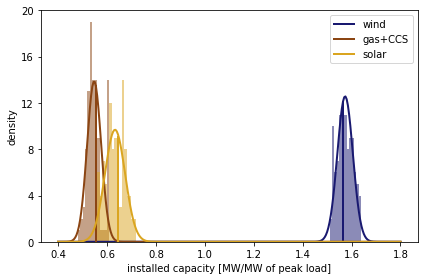

In [27]:
# bootstrap portfolios -- least cost

from scipy.stats import norm

bs_w=np.array([EF[bs].iloc[:16, 0].sum() for bs in range(100)])
bs_s=np.array([EF[bs].iloc[16:32, 0].sum() for bs in range(100)])
bs_g=np.array([EF[bs].iloc[32, 0] for bs in range(100)])

x_bins=np.linspace(0.4, 1.8, 141)
x=np.linspace(0.4, 1.8, 281)

y_w = norm.pdf(x, bs_w.mean(), bs_w.std())
y_s = norm.pdf(x, bs_s.mean(), bs_s.std())
y_g = norm.pdf(x, bs_g.mean(), bs_g.std())

plt.hist(bs_w, bins=x_bins, density=True, color='midnightblue', alpha=0.5)
plt.vlines(bs_w[54], ymin=0, ymax=norm.pdf(bs_w[54], bs_w.mean(), bs_w.std()), color='midnightblue', lw=2)
plt.plot(x, y_w, color='midnightblue', lw=2, label='wind')

plt.hist(bs_g, bins=x_bins, density=True, color='saddlebrown', alpha=0.5)

plt.hist(bs_s, bins=x_bins, density=True, color='goldenrod', alpha=0.5)



plt.plot(x, y_g, color='saddlebrown',  lw=2, label='gas+CCS')
plt.vlines(bs_g[54], ymin=0, ymax=norm.pdf(bs_g[54], bs_g.mean(), bs_g.std()), color='saddlebrown', lw=2)

plt.plot(x, y_s, color='goldenrod',  lw=2, label='solar')
plt.vlines(bs_s[54], ymin=0, ymax=norm.pdf(bs_s[54], bs_s.mean(), bs_s.std()), color='goldenrod', lw=2)


plt.xlabel('installed capacity [MW/MW of peak load]')
plt.ylabel('density')

plt.yticks(np.arange(0, 24, 4))



plt.legend()

plt.tight_layout()
plt.savefig('bootstrap_mincost.png', dpi=300)
plt.show()

In [28]:
# cost and risk estimates
v_bs_mincost_cost=np.array([EF[bs].loc['cost', 1] for bs in range(100)])/annual_demand_bs54
v_bs_mincost_risk=np.sqrt(np.array([EF[bs].loc['sigma_sq', 1] for bs in range(100)]))
v_bs_minrisk_cost=np.array([EF[bs].loc['cost'].values[-1] for bs in range(100)])/annual_demand_bs54
v_bs_minrisk_risk=np.sqrt(np.array([EF[bs].loc['sigma_sq'].values[-1] for bs in range(100)]))

print('mincost cost =', v_bs_mincost_cost.mean(), 'mincost cost std =', v_bs_mincost_cost.std())
print('mincost risk (std) =', v_bs_mincost_risk.mean(), 'mincost risk std =', v_bs_mincost_risk.std())
print('\n')
print('minrisk cost =', v_bs_minrisk_cost.mean(), 'minrisk cost std =', v_bs_minrisk_cost.std())
print('minrisk risk (std)=', v_bs_minrisk_risk.mean(), 'minrisk risk std =', v_bs_minrisk_risk.std())

mincost cost = 45.282573789203454 mincost cost std = 0.5502348844029514
mincost risk (std) = 0.22454320187917592 mincost risk std = 0.005304596539626845


minrisk cost = 87.50570224782433 minrisk cost std = 0.4729724714199182
minrisk risk (std)= 0.11196260155208183 minrisk risk std = 0.0005724477240192141


In [29]:
# translate risk to LOLP/LOLE and USE using full 10-year data

# compute residuals with full 10-year data
df_res_cp_10y=pd.DataFrame(index=s_demand.index, columns=df_cp.columns, 
                             data=-(df_VRE.values@df_cp.iloc[:32].values)) # compute total supply x(-1)
for col in df_res_cp_10y.columns: # add back demand
    df_res_cp_10y[col]=s_demand+df_res_cp_10y[col]
    
df_res_cp_10y.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,-0.178878,-0.155194,-0.147322,-0.134161,-0.108178,-0.067070,-0.039017,0.002517,0.033537,0.058959,0.080643,0.117670,0.149179,0.177045,0.203005,0.251692,0.298221,0.335803
std,0.222879,0.214577,0.211247,0.206651,0.198863,0.188234,0.181530,0.172309,0.165692,0.160380,0.155912,0.148516,0.142407,0.137061,0.132203,0.123434,0.115486,0.112029
min,-1.122483,-1.047642,-1.015986,-0.968644,-0.893355,-0.790640,-0.734217,-0.655466,-0.599995,-0.555736,-0.516944,-0.450733,-0.393860,-0.342037,-0.293412,-0.204004,-0.119219,-0.087619
25%,-0.321616,-0.294876,-0.285622,-0.270678,-0.240383,-0.192943,-0.160696,-0.113411,-0.078071,-0.049171,-0.024614,0.017047,0.052551,0.083858,0.112895,0.167379,0.218709,0.260360
50%,-0.172636,-0.150913,-0.143875,-0.132268,-0.107900,-0.067477,-0.040548,0.000052,0.030567,0.055687,0.077203,0.114081,0.145463,0.173174,0.199140,0.247393,0.293477,0.331950
75%,-0.028362,-0.009858,-0.004349,0.005373,0.025989,0.058914,0.082139,0.117064,0.143440,0.165217,0.183666,0.215543,0.242995,0.267184,0.289770,0.332792,0.374239,0.408442
max,0.619022,0.624168,0.626375,0.629953,0.636556,0.643569,0.650214,0.661827,0.670470,0.678199,0.684221,0.695381,0.704782,0.713639,0.722018,0.737825,0.752817,0.781360


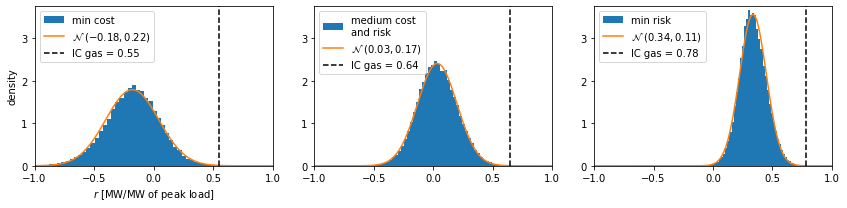

In [30]:
# show VRE residuals follow approx Gaussian distribution

from scipy import stats

fig, ax = plt.subplots(1,3, figsize=(12,3))

l_plot_portfolios=[1, 9, 18]
l_plot_labels=['min cost', 'medium cost \nand risk', 'min risk']
#l_colors=['tab:blue', 'tab:red', 'tab:green']
for i in range(len(l_plot_portfolios)):
    portfolio=l_plot_portfolios[i]
    series=df_res_cp_10y[portfolio]
    # plot histogram
    ax[i].hist(series, bins=50, density=True, label=l_plot_labels[i])
    # plot inferred Gaussian
    x_axis=np.linspace(-1,1, 200)
    #x_axis=np.linspace(-1, 1, 1000)
    _mean=series.mean()
    _std= series.std()
    ax[i].plot(x_axis, stats.norm.pdf(x_axis, _mean, _std), 
               label=r'$\mathcal{N}\;(%0.2f, %0.2f)$' %(np.around(_mean, 2), np.around(_std, 2))) 
    # plot installed capacity of gas
    IC_gas=df_cp.loc['gas', portfolio]
    ax[i].axvline(x=IC_gas, color='k', linestyle='--', label='IC gas = %0.2f' % IC_gas)
    
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(0, 3.75)
    
    #ax[i].set_yscale('log')
    
    ax[i].legend()
    
    if i==0:
        ax[i].set_ylabel('density')
        ax[i].set_xlabel(r'$r$ [MW/MW of peak load]')
    
    #if i!=0:
    #    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [31]:
# convert to common units
# cost in $/MWh 
# compute LOLP= P(r > Xg), LOLE=LOLP*8760, USE=E(r-Xg|r>Xg) 

# metric for the 10 year demand data
N_obs_10y=len(s_demand)
total_demand_10y=s_demand.sum()

df_reliability_cp=pd.DataFrame(index=df_cp.columns, columns=['cost AUD/MWh','LOLP', 'LOLE', 'USE'])
df_reliability_cp['cost AUD/MWh']=df_cp.loc['cost']/annual_demand_bs54 # use bs average
for portfolio in df_cp.columns:
    s_res=df_res_cp_10y[portfolio]
    r_mean=s_res.mean()
    r_std=s_res.std()
    IC_gas=df_cp.loc['gas', portfolio]
    LOLP=1-stats.norm.cdf(IC_gas, r_mean, r_std)
    LOLE=LOLP*8760 # expected number of lost doad days per year
    
    # unserved demand as a percentage of total demand in a year
    USE=stats.norm.expect(lambda x: x-IC_gas, loc=r_mean, scale=r_std, 
                          lb=IC_gas, ub=np.inf)/total_demand_10y*N_obs_10y
    
    df_reliability_cp.loc[portfolio, 'LOLP']=LOLP # *10000000 for generating tables only
    df_reliability_cp.loc[portfolio, 'LOLE']=LOLE
    df_reliability_cp.loc[portfolio, 'USE']=USE #*1000000 for generating tables only
df_reliability_cp

,cost AUD/MWh,LOLP,LOLE,USE
1,45.264753,0.000506,4.430376,0.000044
2,45.323759,0.000427,3.744503,0.000036
3,45.382765,0.000385,3.373801,0.000031
4,45.500777,0.000341,2.987367,0.000027
5,45.840335,0.000273,2.388804,0.00002
6,46.689230,0.000202,1.766893,0.000014
7,47.538125,0.000168,1.468665,0.000011
8,49.235915,0.000136,1.192478,0.000009
9,50.933705,0.000118,1.032585,0.000007
10,52.631496,0.000106,0.92581,0.000006


### constrained

In [32]:
file_zc = open('../model/constrained/result_constrained.pkl', 'rb')

df_zc = pickle.load(file_zc)[54]

file_zc.close()

In [33]:
# add the constant var(d) of bootstrap sample 54 back to the risk indicator which was taken out in the LCQP
vard54=s_demand54.var()

vard54

0.008529405359826856

In [34]:
# solution
df_zc.loc['sigma_sq'][1:]=df_zc.loc['sigma_sq'][1:]+vard54 # add var(demand)   

df_zc[df_zc<0.000001]=0

df_zc

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_wind,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112,0.071112
ADE_wind,0.142028,0.142028,0.142028,0.142028,0.142028,0.142028,0.142028,0.142028,0.142028,0.142028,0.142028,0.132507,0.120346,0.108055,0.093317,0.067623,0.003043,0.000000
SESA_wind,0.023256,0.034282,0.036379,0.034617,0.025517,0.022033,0.022147,0.015950,0.005774,0.000000,0.000000,0.000000,0.000000,0.001919,0.008936,0.018807,0.024521,0.017829
NQ_wind,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693,0.082693
CQ_wind,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798,0.099798
SWQ_wind,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.167561,0.145653,0.140773
SEQ_wind,0.002059,0.066235,0.082297,0.104766,0.133501,0.141937,0.149699,0.150261,0.148368,0.143087,0.133426,0.116179,0.100894,0.087197,0.072940,0.040902,0.050525,0.056465
NNS_wind,0.116660,0.116660,0.116660,0.116660,0.116660,0.116660,0.116660,0.116660,0.100398,0.083284,0.065474,0.045284,0.027999,0.011766,0.000000,0.000000,0.000000,0.000000
NCEN_wind,0.220176,0.206009,0.203939,0.197269,0.175199,0.160634,0.134503,0.114607,0.100429,0.093593,0.088142,0.080826,0.077990,0.075856,0.073083,0.053757,0.038553,0.031022
SWNSW_wind,0.086327,0.086327,0.086327,0.086327,0.086327,0.086327,0.086327,0.086327,0.086327,0.086327,0.086327,0.074964,0.060614,0.049342,0.037022,0.012392,0.000000,0.000000


In [35]:
# compute residuals with full 10-year data
df_res_zc_10y=pd.DataFrame(index=s_demand.index, columns=df_zc.columns, 
                             data=-(df_VRE.values@df_zc.iloc[:32].values)) # compute total supply x(-1)
for col in df_res_zc_10y.columns: # add back demand
    df_res_zc_10y[col]=s_demand+df_res_zc_10y[col]
    
df_res_zc_10y.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,-0.154998,-0.125494,-0.112244,-0.093790,-0.065322,-0.044067,-0.012481,0.011951,0.049571,0.079008,0.103902,0.144411,0.178421,0.208476,0.235926,0.287085,0.333118,0.341957
std,0.286710,0.266544,0.259305,0.249913,0.237081,0.228495,0.216595,0.207935,0.195162,0.185694,0.178032,0.165851,0.155924,0.147426,0.139891,0.126701,0.117552,0.117397
min,-1.319523,-1.230976,-1.192645,-1.142132,-1.069263,-1.019387,-0.943282,-0.883987,-0.786934,-0.709335,-0.646949,-0.550874,-0.468917,-0.397260,-0.333250,-0.216820,-0.145527,-0.143439
25%,-0.327589,-0.287690,-0.271318,-0.248082,-0.212487,-0.186541,-0.148544,-0.119128,-0.074030,-0.039136,-0.010035,0.037830,0.077783,0.113055,0.145218,0.204086,0.255889,0.265131
50%,-0.130212,-0.106283,-0.094563,-0.077913,-0.051484,-0.031860,-0.002469,0.021107,0.056583,0.084683,0.108068,0.146941,0.179875,0.208747,0.235152,0.284320,0.329316,0.338326
75%,0.042744,0.057060,0.065190,0.076735,0.096232,0.111015,0.133891,0.151909,0.180431,0.203084,0.222216,0.254113,0.280955,0.304747,0.326920,0.369204,0.408478,0.416997
max,0.736450,0.732590,0.731550,0.730175,0.733121,0.737240,0.743646,0.746745,0.753157,0.758633,0.763028,0.770415,0.776969,0.782655,0.788364,0.798284,0.808225,0.814752


In [36]:
# convert to common units
# cost in $/MWh 
# compute LOLP= P(r > Xg), LOLE=LOLP*8760, USE=E(r-Xg|r>Xg) 

# metric for the 10 year demand data

df_reliability_zc=pd.DataFrame(index=df_zc.columns, columns=['cost AUD/MWh','LOLP', 'LOLE', 'USE'])
df_reliability_zc['cost AUD/MWh']=df_zc.loc['cost']/annual_demand_bs54 # use bs average 
for portfolio in df_zc.columns:
    s_res=df_res_zc_10y[portfolio]
    r_mean=s_res.mean()
    r_std=s_res.std()
    IC_gas=df_zc.loc['gas', portfolio]
    LOLP=1-stats.norm.cdf(IC_gas, r_mean, r_std)
    LOLE=LOLP*8760 # expected number of lost doad days per year
    
    # unserved demand as a percentage of total demand in a year
    USE=stats.norm.expect(lambda x: x-IC_gas, loc=r_mean, scale=r_std, 
                          lb=IC_gas, ub=np.inf)/total_demand_10y*N_obs_10y
    
    df_reliability_zc.loc[portfolio, 'LOLP']=LOLP
    df_reliability_zc.loc[portfolio, 'LOLE']=LOLE
    df_reliability_zc.loc[portfolio, 'USE']=USE
df_reliability_zc

,cost AUD/MWh,LOLP,LOLE,USE
1,53.091274,0.001429,12.52066,0.000173
2,53.188553,0.000808,7.079809,0.000087
3,53.285832,0.00066,5.784881,0.000068
4,53.480391,0.000513,4.489623,0.00005
5,53.904838,0.000379,3.318673,0.000035
6,54.329286,0.000314,2.74926,0.000027
7,55.178181,0.000241,2.107933,0.00002
8,56.027076,0.000205,1.794411,0.000016
9,57.724866,0.000156,1.366539,0.000011
10,59.422656,0.000126,1.10503,0.000008


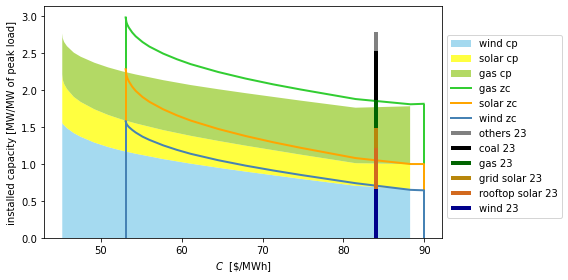

In [37]:
# compare investment decisions
plt.figure(figsize=(8,4))
# current mix
Xw23=df_gen_info.loc['onshore', 'capacity_MW_Oct23']/peak_demand23
Xrts23=df_gen_info.loc['rooftop solar', 'capacity_MW_Oct23'].sum()/peak_demand23
Xgs23=df_gen_info.loc['grid solar', 'capacity_MW_Oct23'].sum()/peak_demand23
Xg23=df_gen_info.loc['gasCCS', 'capacity_MW_Oct23']/peak_demand23
Xc23=Xw23=df_gen_info.loc['coalCCS', 'capacity_MW_Oct23']/peak_demand23
Xother23=df_gen_info.loc[['hydro', 'biomass'], 'capacity_MW_Oct23'].sum()/peak_demand23

# copperplate
cp_costs=df_cp.loc['cost'].values/annual_demand_bs54
cp_wind_total=df_cp.iloc[:16].sum(axis=0).values
cp_solar_total=df_cp.iloc[16:32].sum(axis=0).values
cp_gas=df_cp.loc['gas'].values

# constrained
zc_costs=df_zc.loc['cost'].values/annual_demand_bs54
zc_wind_total=df_zc.iloc[:16].sum(axis=0).values
zc_solar_total=df_zc.iloc[16:32].sum(axis=0).values
zc_gas=df_zc.loc['gas'].values


# plot

## copperplate
plt.stackplot(cp_costs, cp_wind_total, cp_solar_total, cp_gas , colors=['skyblue', 'yellow', 'yellowgreen'],
              alpha=0.75, labels=['wind cp', 'solar cp', 'gas cp'])
## constrained

l_gas=zc_wind_total+zc_solar_total+zc_gas
plt.plot(zc_costs, l_gas, color='limegreen', lw=2, label='gas zc') # gas
plt.vlines(x=zc_costs[0], ymin=0, ymax=l_gas[0], lw=2, color='limegreen')
plt.vlines(x=zc_costs[-1], ymin=0, ymax=l_gas[-1], lw=2, color='limegreen')

l_solar=zc_wind_total+zc_solar_total
plt.plot(zc_costs, l_solar, color='orange',lw=2, label='solar zc')
plt.vlines(x=zc_costs[0], ymin=0, ymax=l_solar[0], lw=2, color='orange')
plt.vlines(x=zc_costs[-1], ymin=0, ymax=l_solar[-1], lw=2, color='orange')

plt.plot(zc_costs, zc_wind_total, color='steelblue', lw=2, label='wind zc')
plt.vlines(x=zc_costs[0], ymin=0, ymax=zc_wind_total[0],lw=2, color='steelblue')
plt.vlines(x=zc_costs[-1], ymin=0, ymax=zc_wind_total[-1],lw=2, color='steelblue')

# current mix
plt.vlines(x=cost23_AUDpMWh, ymin=0, ymax=Xother23+Xc23+Xg23+Xgs23+Xrts23+Xw23,  color='grey', lw=4, label="others 23")
plt.vlines(x=cost23_AUDpMWh, ymin=0, ymax=Xc23+Xg23+Xgs23+Xrts23+Xw23,  color='k', lw=4, label="coal 23")
plt.vlines(x=cost23_AUDpMWh, ymin=0, ymax=Xg23+Xgs23+Xrts23+Xw23,  color='darkgreen', lw=4, label="gas 23")
plt.vlines(x=cost23_AUDpMWh, ymin=0, ymax=Xgs23+Xrts23+Xw23,  color='darkgoldenrod', lw=4, label='grid solar 23')
plt.vlines(x=cost23_AUDpMWh, ymin=0, ymax=Xrts23+Xw23,  color='chocolate', lw=4, label='rooftop solar 23')
plt.vlines(x=cost23_AUDpMWh, ymin=0, ymax=Xw23,  color='darkblue', lw=4, label='wind 23')

plt.xlabel(r"${C} $ " +" [\$/MWh]")
plt.ylabel('installed capacity [MW/MW of peak load]')

plt.legend( bbox_to_anchor=(1, 0.9))

plt.tight_layout()

plt.savefig('portfolios.png', dpi=300)

plt.show()

In [38]:
# lagrange multipliers
file_LM = open('../model/constrained/LM.pkl', 'rb')

df_LM = pickle.load(file_LM)[54]

file_LM.close()

df_LM[df_LM.abs()<0.000001]=0
df_LM

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_max,-33915.193156,0.164174,0.109857,0.074870,0.048606,0.036532,0.026181,0.021175,0.015515,0.011991,0.009844,0.007533,0.006206,0.005197,0.004438,0.003136,0.001585,0.001116
ADE_max,-19111.660182,0.087205,0.057055,0.037673,0.023202,0.016781,0.010975,0.008468,0.005547,0.003709,0.002466,0.001539,0.001166,0.000902,0.000728,0.000447,0.000000,0.000000
SESA_max,-1791.235543,0.008079,0.005715,0.004647,0.003431,0.002701,0.001960,0.001649,0.001309,0.001097,0.000958,0.000721,0.000493,0.000334,0.000260,0.000123,0.000000,0.000000
NQ_max,-72522.598197,0.353563,0.235751,0.160969,0.106249,0.082251,0.061131,0.050335,0.038580,0.032147,0.027939,0.022621,0.019121,0.016427,0.014255,0.010611,0.006216,0.005799
CQ_max,-35059.909082,0.177215,0.119802,0.083478,0.056271,0.044102,0.033399,0.027658,0.020934,0.017199,0.014894,0.011875,0.009853,0.008252,0.006941,0.004688,0.002081,0.001795
SWQ_max,-20923.226613,0.096817,0.063295,0.041593,0.026022,0.019108,0.013068,0.010084,0.006830,0.005133,0.004207,0.003176,0.002528,0.001997,0.001572,0.000530,0.000000,0.000000
SEQ_max,0.000000,0.000265,0.000925,0.001447,0.001315,0.001289,0.001003,0.000798,0.000199,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NNS_max,-4137.171233,0.020116,0.013540,0.008752,0.005463,0.003705,0.002092,0.001200,0.000413,0.000038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NCEN_max,-58.704716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SWNSW_max,-13748.944510,0.063485,0.040495,0.026465,0.015781,0.010567,0.006712,0.004838,0.002805,0.001451,0.000730,0.000214,0.000097,0.000019,0.000000,0.000000,0.000000,0.000000


In [39]:
# divide d(Var(r)) by 2\sigma to get rate of change of sigma with respect to change in X bounds
# divide by sigma again to get percentage change

# from portfolio 2 - portfolio 1 is cost minimisation
df_dsigma=df_LM.iloc[:, 1:].copy()

df_dsigma_pc=df_LM.iloc[:, 1:].copy()

for portfolio in df_dsigma:
    sigma=np.sqrt(df_zc.loc['sigma_sq', portfolio])
    dsigma=df_dsigma[portfolio]/2/sigma
    df_dsigma[portfolio]=dsigma
    df_dsigma_pc[portfolio]=dsigma/sigma
df_dsigma_pc

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_max,1.167932,0.826022,0.606363,0.437717,0.354325,0.282787,0.248212,0.206415,0.176179,0.157363,0.138767,0.129359,0.121170,0.114933,0.098980,0.058174,0.041114
ADE_max,0.620378,0.428999,0.305109,0.208946,0.162757,0.118543,0.099257,0.073806,0.054502,0.039413,0.028358,0.024310,0.021027,0.018864,0.014122,0.000000,0.000000
SESA_max,0.057475,0.042971,0.037635,0.030900,0.026197,0.021175,0.019326,0.017419,0.016120,0.015310,0.013282,0.010269,0.007784,0.006744,0.003867,0.000000,0.000000
NQ_max,2.515248,1.772627,1.303675,0.956808,0.797760,0.660285,0.590020,0.513291,0.472334,0.446615,0.416724,0.398541,0.383024,0.369179,0.334957,0.228201,0.213720
CQ_max,1.260706,0.900798,0.676082,0.506736,0.427755,0.360744,0.324204,0.278518,0.252695,0.238085,0.218756,0.205360,0.192407,0.179766,0.147992,0.076399,0.066171
SWQ_max,0.688758,0.475920,0.336855,0.234334,0.185328,0.141145,0.118198,0.090867,0.075412,0.067244,0.058507,0.052695,0.046571,0.040711,0.016744,0.000000,0.000000
SEQ_max,0.001887,0.006952,0.011718,0.011844,0.012503,0.010830,0.009356,0.002644,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NNS_max,0.143105,0.101805,0.070884,0.049194,0.035931,0.022597,0.014063,0.005493,0.000557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NCEN_max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SWNSW_max,0.451634,0.304482,0.214340,0.142110,0.102492,0.072494,0.056709,0.037312,0.021326,0.011663,0.003942,0.002026,0.000450,0.000000,0.000000,0.000000,0.000000


In [40]:
# similarly, divide by cost to obtain % cost savings for portfolio 1
s_dC_pc=df_LM[1]/df_zc.loc['cost', 1]
s_dC_pc

NSA_max     -0.108456
ADE_max     -0.061117
SESA_max    -0.005728
NQ_max      -0.231918
CQ_max      -0.112117
SWQ_max     -0.066910
SEQ_max      0.000000
NNS_max     -0.013230
NCEN_max    -0.000188
SWNSW_max   -0.043967
CAN_max      0.000000
CVIC_max    -0.003753
NVIC_max     0.000000
MEL_max      0.000000
LV_max       0.000000
TAS_max     -0.263699
ADE_min      0.000000
SEQ_min      0.000000
NCEN_min     0.000000
MEL_min      0.000000
TAS_min      0.000000
Name: 1, dtype: float64

In [41]:
s_dC_pc.nsmallest()

TAS_max   -0.263699
NQ_max    -0.231918
CQ_max    -0.112117
NSA_max   -0.108456
SWQ_max   -0.066910
Name: 1, dtype: float64

In [42]:
df_dsigma_pc[18].nlargest()

NQ_max      0.213720
CQ_max      0.066171
NSA_max     0.041114
NCEN_min    0.038327
TAS_max     0.016652
Name: 18, dtype: float64

### battery -- copperplate

In [43]:
# with battery, copperplate
df_res_cpb=pd.read_csv('../model/battery/bs54_shifted_residuals.csv')
df_res_cpb['AEST']=pd.to_datetime(df_res_cpb['AEST'])
df_res_cpb=df_res_cpb.set_index('AEST')
df_res_cpb.columns=df_res_cpb.columns.astype(int)
df_res_cpb.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,87672.000000,87672.000000,8.767200e+04,87672.000000,87672.000000,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04
mean,-0.178878,-1.551941e-01,-1.473221e-01,-1.341609e-01,-1.081782e-01,-0.067070,-0.039017,2.517163e-03,0.033537,0.058959,8.064328e-02,0.117670,0.149179,0.177045,0.203005,0.251692,2.982206e-01,3.358035e-01
std,0.201536,1.929103e-01,1.895237e-01,1.847118e-01,1.760554e-01,0.164451,0.157367,1.482678e-01,0.142567,0.138590,1.357057e-01,0.131737,0.129360,0.127401,0.125482,0.120951,1.149120e-01,1.118112e-01
min,-0.950466,-8.792591e-01,-8.505161e-01,-8.063107e-01,-7.364869e-01,-0.665580,-0.621959,-5.551087e-01,-0.501250,-0.454615,-4.115789e-01,-0.339083,-0.269104,-0.218597,-0.174712,-0.082752,-1.339083e-10,-1.605363e-10
25%,-0.312173,-2.844278e-01,-2.752512e-01,-2.593249e-01,-2.270919e-01,-0.176503,-0.140873,-8.690827e-02,-0.045809,-0.011609,-1.441366e-09,0.005747,0.046828,0.081124,0.111614,0.167082,2.186345e-01,2.603596e-01
50%,-0.163009,-1.395697e-01,-1.321037e-01,-1.190892e-01,-9.151011e-02,-0.045777,-0.012943,4.432433e-11,0.005438,0.036693,6.193982e-02,0.105094,0.140711,0.170905,0.198116,0.247339,2.934670e-01,3.319504e-01
75%,-0.010502,-2.211565e-09,-1.969391e-10,8.988796e-11,1.885702e-09,0.017144,0.046153,9.063071e-02,0.122252,0.147757,1.704485e-01,0.207621,0.237432,0.263830,0.287883,0.332421,3.742388e-01,4.084418e-01
max,0.423661,4.305998e-01,4.338056e-01,4.389193e-01,4.477962e-01,0.464859,0.476783,4.932594e-01,0.515676,0.531359,5.416921e-01,0.556865,0.576437,0.589962,0.626660,0.665590,7.528167e-01,7.756434e-01


In [44]:
Xg_cpb=df_res_cpb.max()
Xg_cpb

1     0.423661
2     0.430600
3     0.433806
4     0.438919
5     0.447796
6     0.464859
7     0.476783
8     0.493259
9     0.515676
10    0.531359
11    0.541692
12    0.556865
13    0.576437
14    0.589962
15    0.626660
16    0.665590
17    0.752817
18    0.775643
dtype: float64

In [45]:
# compute cost $/MWh

# cost params
cfixed_wind=df_gen_cost.loc['onshore','CAP [AUD/kW]' ]*1000/25 + \
            df_gen_cost.loc['onshore','fixed O&M [AUD/kW/yr]']*1000
cfixed_solar=df_gen_cost.loc['solar','CAP [AUD/kW]' ]*1000/25 + \
            df_gen_cost.loc['solar','fixed O&M [AUD/kW/yr]']*1000
cfixed_gas=df_gen_cost.loc['gasCCS','CAP [AUD/kW]' ]*1000/25 + \
            df_gen_cost.loc['gasCCS','fixed O&M [AUD/kW/yr]']*1000
cvar_gas=df_gen_cost.loc['gasCCS', ['variable O&M [AUD/MWh]', 'CO2 store [AUD/MWh]', 'fuel [AUD/MWh]']].sum()

# positive residuals are severed by gas
df_resplus_cpb=df_res_cpb.clip(lower=0)
s_annual_resplus_cpb=df_resplus_cpb.sum()/10

s_costs_cpb=cfixed_wind*cp_wind_total+cfixed_solar*cp_solar_total+cfixed_gas*Xg_cpb+ cvar_gas*s_annual_resplus_cpb \
+ 0.8*162000/10
s_costs_cpb

1     251349.419437
2     251326.293025
3     251615.375572
4     252143.000704
5     253033.981730
6     256682.153684
7     261068.725770
8     270947.716543
9     282885.306427
10    294629.950201
11    306014.219162
12    328825.341790
13    352473.436127
14    374640.592522
15    399672.599932
16    443966.148650
17    493671.403898
18    532197.469732
dtype: float64

In [46]:
df_charge_cpb=pd.read_csv('../model/battery/bs54_charge.csv')
df_charge_cpb['AEST']=pd.to_datetime(df_charge_cpb['AEST'])
df_charge_cpb=df_charge_cpb.set_index('AEST')
df_charge_cpb.columns=df_charge_cpb.columns.astype(int)
df_charge_cpb.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04
mean,2.832608e-11,2.723914e-11,2.800349e-11,2.538816e-11,2.508069e-11,2.203701e-11,1.078337e-11,-4.096065e-12,-1.298528e-11,-1.924321e-11,-2.520206e-11,-3.114821e-11,-3.479879e-11,-3.871177e-11,-4.486103e-11,-4.561400e-11,-4.556951e-11,-4.555035e-11
std,4.831987e-02,4.856634e-02,4.847129e-02,4.859547e-02,4.986711e-02,5.138710e-02,5.182631e-02,5.097795e-02,4.906894e-02,4.671205e-02,4.415742e-02,3.791073e-02,3.093893e-02,2.463447e-02,1.894125e-02,9.515046e-03,3.400702e-03,1.785588e-03
min,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-1.924419e-01,-1.162687e-01,-8.604240e-02
25%,5.749141e-11,3.342098e-11,3.474435e-11,-1.344669e-10,-1.268854e-09,-3.165948e-09,-5.857548e-09,-9.992426e-09,-8.787614e-09,-7.889903e-09,-4.728958e-09,-2.964308e-09,-1.060752e-09,-9.673661e-10,-3.102462e-10,-8.395241e-11,-3.688697e-11,-3.831848e-11
50%,4.822938e-10,8.603228e-10,4.039389e-10,4.700598e-10,8.888298e-10,8.719644e-10,8.870739e-10,-4.148360e-11,-3.749903e-10,-5.297610e-10,-1.984047e-10,-3.707073e-10,-2.413332e-10,-1.849767e-10,-9.492900e-11,-2.854076e-11,-1.291560e-11,-9.366027e-12
75%,5.782974e-09,9.269729e-09,6.159791e-09,6.618066e-09,2.596713e-08,7.976304e-08,9.047955e-04,1.904026e-03,1.712588e-07,1.889990e-08,2.370950e-09,-3.096556e-11,-5.232597e-11,-3.807637e-11,-2.836392e-11,-7.616275e-12,-3.420697e-12,-3.206595e-12
max,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,1.999998e-01,1.971843e-01,1.913313e-01,1.877548e-01,1.639733e-01,1.192192e-01,8.761885e-02


In [47]:
# find max discharge (charge rates are negative)

max_peakshave_cpb=df_charge_cpb.min()*(-1)
max_peakshave_cpb

1     0.200000
2     0.200000
3     0.200000
4     0.200000
5     0.200000
6     0.200000
7     0.200000
8     0.200000
9     0.200000
10    0.200000
11    0.200000
12    0.200000
13    0.200000
14    0.200000
15    0.200000
16    0.192442
17    0.116269
18    0.086042
dtype: float64

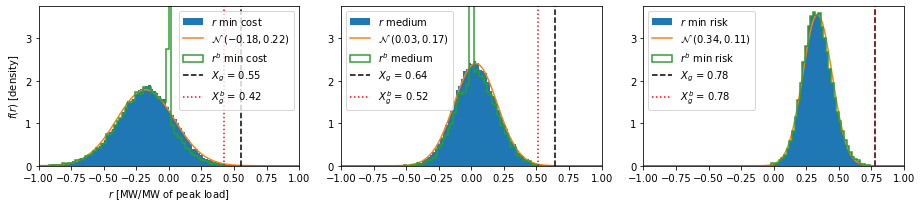

In [48]:
# show the effect of load shifting on the distribution of the residual demand that must be met by gas

fig, ax = plt.subplots(1,3, figsize=(13,3))

l_plot_portfolios=[1, 9, 18]
l_plot_labels=['min cost', 'medium', 'min risk']
bins=np.linspace(-1, 1, 101)
#l_colors=['tab:blue', 'tab:red', 'tab:green']
for i in range(len(l_plot_portfolios)):
    portfolio=l_plot_portfolios[i]
    series=df_res_cp_10y[portfolio]
    # plot histogram
    ax[i].hist(series, bins=bins, density=True, label=r'$r$ '+l_plot_labels[i])
    # plot inferred Gaussian
    x_axis=np.linspace(-1,1, 200)
    #x_axis=np.linspace(-1, 1, 1000)
    _mean=series.mean()
    _std= series.std()
    ax[i].plot(x_axis, stats.norm.pdf(x_axis, _mean, _std), 
               label=r'$\mathcal{N}\;(%0.2f, %0.2f)$' %(np.around(_mean, 2), np.around(_std, 2))) 
   
    
    ax[i].hist(df_res_cpb[portfolio], bins=bins, density=True, histtype='step', lw=1.5, 
               label=r'$r^b$ '+l_plot_labels[i])
    
    # plot installed capacity of gas
    IC_gas=df_cp.loc['gas', portfolio]
    ax[i].axvline(x=IC_gas, color='k', linestyle='--', label='$X_g$ = %0.2f' % IC_gas)
    IC_gas_battery=Xg_cpb[portfolio]
    ax[i].axvline(x=IC_gas_battery, color='r', linestyle=':', label='$X_g^{b}$ = %0.2f' % IC_gas_battery)
    
    
    
    
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(0, 3.75)
    
    #ax[i].set_yscale('log')
    
    ax[i].legend()
    
    if i==0:
        ax[i].set_ylabel('$f(r)$ [density]')
        ax[i].set_xlabel(r'$r$ [MW/MW of peak load]')
    
    #if i!=0:
    #    ax[i].set_yticks([])
plt.tight_layout()

#plt.savefig('res_distribution.png', dpi=300)

plt.show()

In [49]:
# occasions when residual<0 in the least risk portfolio without battery
df_res_cp_10y[18][df_res_cp_10y[18]<0]

AEST
2000-04-25 10:00:00   -0.060674
2000-04-25 11:00:00   -0.080635
2000-04-25 12:00:00   -0.068066
2000-04-25 13:00:00   -0.046244
2000-04-25 14:00:00   -0.014485
                         ...   
2009-09-12 13:00:00   -0.041654
2009-09-12 14:00:00   -0.005799
2009-09-26 13:00:00   -0.001800
2009-09-27 08:00:00   -0.032216
2009-09-27 09:00:00   -0.005694
Name: 18, Length: 122, dtype: float64

In [50]:
# Loss of load probability: distribution NOT Gaussian after load shifting 
# Estimate probability of VRE residual without load shifting - max peak shaving > new Xg

df_reliability_cpb=pd.DataFrame(index=df_cp.columns, columns=['cost AUD/MWh','LOLP', 'LOLE', 'USE'])
df_reliability_cpb['cost AUD/MWh']=s_costs_cpb/annual_demand_10y
for portfolio in df_cp.columns:
    s_res=df_res_cp_10y[portfolio] # original residuals without load shifting
    r_mean=s_res.mean()
    r_std=s_res.std()
    IC_gas=Xg_cpb[portfolio]
    peakshave_max=max_peakshave_cpb[portfolio]
    LOLP=1-stats.norm.cdf(IC_gas+peakshave_max, r_mean, r_std)
    LOLE=LOLP*8760 # expected number of lost doad days per year
    
    # unserved demand as a percentage of total demand in a year
    USE=stats.norm.expect(lambda x: x-IC_gas-peakshave_max, loc=r_mean, scale=r_std, 
                          lb=IC_gas+peakshave_max, ub=np.inf)/total_demand_10y*N_obs_10y
    
    df_reliability_cpb.loc[portfolio, 'LOLP']=LOLP
    df_reliability_cpb.loc[portfolio, 'LOLE']=LOLE
    df_reliability_cpb.loc[portfolio, 'USE']=USE
df_reliability_cpb

,cost AUD/MWh,LOLP,LOLE,USE
1,42.652408,0.000159,1.389605,0.000013
2,42.648484,0.000125,1.095852,0.00001
3,42.697539,0.000109,0.952901,0.000008
4,42.787074,0.000092,0.802841,0.000007
5,42.938268,0.000072,0.629966,0.000005
6,43.557339,0.00005,0.441968,0.000003
7,44.301713,0.00004,0.352239,0.000002
8,45.978115,0.000031,0.26737,0.000002
9,48.003849,0.000019,0.168176,0.000001
10,49.996841,0.000014,0.120817,0.000001


### battery -- constrained

In [51]:
# with battery, copperplate
df_res_zcb=pd.read_csv('../model/constrained/bs54_constrained_shifted_residuals.csv')
df_res_zcb['AEST']=pd.to_datetime(df_res_zcb['AEST'])
df_res_zcb=df_res_zcb.set_index('AEST')
df_res_zcb.columns=df_res_zcb.columns.astype(int)
df_res_zcb.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04,87672.000000,8.767200e+04,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04
mean,-1.549976e-01,-0.125494,-0.112244,-0.093790,-0.065322,-0.044067,-1.248119e-02,1.195065e-02,0.049571,7.900814e-02,1.039020e-01,0.144411,0.178421,0.208476,0.235926,0.287085,3.331179e-01,3.419569e-01
std,2.616426e-01,0.241398,0.234066,0.224548,0.211787,0.203362,1.918194e-01,1.837243e-01,0.172151,1.641653e-01,1.582584e-01,0.149576,0.143173,0.138114,0.133564,0.124455,1.169785e-01,1.168926e-01
min,-1.161405e+00,-1.077507,-1.044261,-1.000246,-0.933279,-0.881561,-8.037291e-01,-7.453520e-01,-0.651621,-5.789526e-01,-5.200718e-01,-0.429779,-0.354639,-0.283607,-0.203162,-0.061375,-3.827356e-10,-1.969652e-10
25%,-3.146072e-01,-0.272030,-0.254640,-0.230552,-0.192875,-0.165316,-1.224915e-01,-8.981095e-02,-0.039802,-2.949155e-07,-2.596904e-10,0.027884,0.073055,0.110409,0.144406,0.203994,2.558890e-01,2.651310e-01
50%,-1.122410e-01,-0.087850,-0.075053,-0.056371,-0.026550,-0.004083,-2.183698e-10,8.128374e-09,0.037212,7.070599e-02,9.822837e-02,0.141067,0.176878,0.207541,0.234718,0.284292,3.293002e-01,3.383123e-01
75%,7.098039e-08,0.015937,0.025112,0.038827,0.061659,0.080152,1.068788e-01,1.280917e-01,0.161291,1.879779e-01,2.097085e-01,0.246210,0.276315,0.301714,0.325300,0.369083,4.084254e-01,4.169823e-01
max,5.729000e-01,0.574026,0.575111,0.576996,0.581017,0.584769,5.909443e-01,5.962389e-01,0.604805,6.118076e-01,6.180006e-01,0.627506,0.654103,0.671207,0.677883,0.712763,7.690614e-01,7.736760e-01


In [52]:
Xg_zcb=df_res_zcb.max()
Xg_zcb

1     0.572900
2     0.574026
3     0.575111
4     0.576996
5     0.581017
6     0.584769
7     0.590944
8     0.596239
9     0.604805
10    0.611808
11    0.618001
12    0.627506
13    0.654103
14    0.671207
15    0.677883
16    0.712763
17    0.769061
18    0.773676
dtype: float64

In [53]:
# positive residuals are severed by gas
df_resplus_zcb=df_res_zcb.clip(lower=0)
s_annual_resplus_zcb=df_resplus_zcb.sum()/10

s_costs_zcb=cfixed_wind*zc_wind_total+cfixed_solar*zc_solar_total+cfixed_gas*Xg_zcb+ \
            cvar_gas*s_annual_resplus_zcb + 0.8*162000/10
s_costs_zcb

1     295145.131288
2     293926.656043
3     293813.084044
4     294243.867617
5     296410.460306
6     298954.728905
7     304231.703273
8     309986.810860
9     321297.373839
10    332805.914063
11    344477.642459
12    367150.718864
13    392105.076949
14    415387.834201
15    436744.299078
16    481428.649957
17    527912.527050
18    537170.865658
dtype: float64

In [54]:
df_charge_zcb=pd.read_csv('../model/constrained/bs54_constrained_charge.csv')
df_charge_zcb['AEST']=pd.to_datetime(df_charge_zcb['AEST'])
df_charge_zcb=df_charge_zcb.set_index('AEST')
df_charge_zcb.columns=df_charge_zcb.columns.astype(int)
df_charge_zcb.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04
mean,1.285507e-11,1.158038e-11,1.223118e-11,1.070323e-11,9.571579e-12,7.306023e-12,2.392877e-12,-7.137065e-13,-6.871207e-12,-1.459785e-11,-2.215197e-11,-3.285573e-11,-3.632070e-11,-3.655189e-11,-4.102520e-11,-4.560645e-11,-4.556775e-11,-4.558397e-11
std,5.669526e-02,5.604910e-02,5.596213e-02,5.582739e-02,5.533679e-02,5.483821e-02,5.374170e-02,5.234075e-02,4.963951e-02,4.634303e-02,4.280482e-02,3.636204e-02,2.984099e-02,2.351734e-02,1.784894e-02,8.592278e-03,3.484548e-03,3.203329e-03
min,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-2.000000e-01,-1.581634e-01,-9.992912e-02,-1.002417e-01
25%,-1.820385e-09,-5.368576e-09,-4.491941e-09,-4.109884e-09,-5.116053e-09,-6.698237e-09,-1.020535e-08,-1.001327e-08,-1.041672e-08,-6.855689e-09,-5.711883e-09,-4.191489e-09,-1.703657e-09,-5.611319e-10,-3.124023e-10,-8.280333e-11,-4.873932e-11,-3.115868e-11
50%,6.016060e-10,1.069456e-09,9.858475e-10,7.182540e-10,3.008833e-10,2.537648e-10,6.582075e-11,-1.415035e-10,-2.757085e-10,-4.949885e-10,-5.196501e-10,-6.796137e-10,-3.874401e-10,-1.502597e-10,-1.103476e-10,-2.933737e-11,-2.332251e-11,-7.123950e-12
75%,6.611180e-09,1.195723e-08,1.133115e-08,1.110713e-08,9.634091e-09,1.152227e-08,1.617247e-08,1.131223e-08,6.191722e-09,2.648153e-09,3.614361e-10,-5.257708e-11,-4.952811e-11,-3.938269e-11,-3.817175e-11,-7.818749e-12,-3.143494e-12,-2.860570e-12
max,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01,1.861855e-01,1.658698e-01,1.455265e-01,1.434390e-01


In [55]:
# find max discharge (charge rates are negative)

max_peakshave_zcb=df_charge_zcb.min()*(-1)
max_peakshave_zcb


1     0.200000
2     0.200000
3     0.200000
4     0.200000
5     0.200000
6     0.200000
7     0.200000
8     0.200000
9     0.200000
10    0.200000
11    0.200000
12    0.200000
13    0.200000
14    0.200000
15    0.200000
16    0.158163
17    0.099929
18    0.100242
dtype: float64

In [56]:
# Loss of load probability: distribution NOT Gaussian after load shifting 
# Estimate probability of VRE residual without load shifting - max peak shaving > new Xg

df_reliability_zcb=pd.DataFrame(index=df_zc.columns, columns=['cost AUD/MWh','LOLP', 'LOLE', 'USE'])
df_reliability_zcb['cost AUD/MWh']=s_costs_zcb/annual_demand_10y
for portfolio in df_zc.columns:
    s_res=df_res_zc_10y[portfolio] # original residuals without load shifting
    r_mean=s_res.mean()
    r_std=s_res.std()
    IC_gas=Xg_zcb[portfolio]
    peakshave_max=max_peakshave_zcb[portfolio]
    LOLP=1-stats.norm.cdf(IC_gas+peakshave_max, r_mean, r_std)
    LOLE=LOLP*8760 # expected number of lost doad days per year
    
    # unserved demand as a percentage of total demand in a year
    USE=stats.norm.expect(lambda x: x-IC_gas-peakshave_max, loc=r_mean, scale=r_std, 
                          lb=IC_gas+peakshave_max, ub=np.inf)/total_demand_10y*N_obs_10y
    
    df_reliability_zcb.loc[portfolio, 'LOLP']=LOLP
    df_reliability_zcb.loc[portfolio, 'LOLE']=LOLE
    df_reliability_zcb.loc[portfolio, 'USE']=USE
df_reliability_zcb

,cost AUD/MWh,LOLP,LOLE,USE
1,50.084264,0.000605,5.302499,0.000069
2,49.877496,0.000369,3.236029,0.000038
3,49.858224,0.000311,2.72224,0.000031
4,49.931325,0.000247,2.160797,0.000023
5,50.298982,0.000179,1.564582,0.000016
6,50.730728,0.000143,1.254091,0.000012
7,51.626197,0.000104,0.910141,0.000008
8,52.602803,0.000081,0.709906,0.000006
9,54.522134,0.000054,0.477146,0.000004
10,56.475060,0.00004,0.347661,0.000003


In [57]:
df_reliability_zc

,cost AUD/MWh,LOLP,LOLE,USE
1,53.091274,0.001429,12.52066,0.000173
2,53.188553,0.000808,7.079809,0.000087
3,53.285832,0.00066,5.784881,0.000068
4,53.480391,0.000513,4.489623,0.00005
5,53.904838,0.000379,3.318673,0.000035
6,54.329286,0.000314,2.74926,0.000027
7,55.178181,0.000241,2.107933,0.00002
8,56.027076,0.000205,1.794411,0.000016
9,57.724866,0.000156,1.366539,0.000011
10,59.422656,0.000126,1.10503,0.000008


In [58]:
df_reliability_zc.loc[1, 'LOLP']/df_reliability_cp.loc[1, 'LOLP']

2.826094115214849

In [59]:
df_reliability_zc.loc[1, 'USE']/df_reliability_cp.loc[1, 'USE']

3.9146845065037996

In [60]:
(df_reliability_cp.iloc[0,0]-df_reliability_cpb.iloc[0,0])/df_reliability_cp.iloc[0,0]

0.05771257356631812

In [61]:
df_reliability_cp.iloc[0,-1]-df_reliability_cpb.iloc[0,-1]

3.1354355107347815e-05

In [62]:
(df_reliability_zc.iloc[0,0]-df_reliability_zcb.iloc[0,0])/df_reliability_zc.iloc[0,0]

0.056638508049300144

### comparisons -- trade-offs

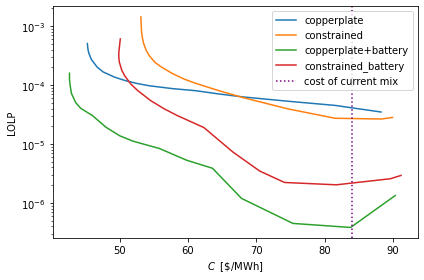

In [63]:
# plot cost of LOLP 

plt.plot(df_reliability_cp['cost AUD/MWh'], df_reliability_cp['LOLP'].values, label='copperplate')
plt.plot(df_reliability_zc['cost AUD/MWh'], df_reliability_zc['LOLP'].values, label='constrained')
plt.plot(df_reliability_cpb['cost AUD/MWh'], df_reliability_cpb['LOLP'].values, label='copperplate+battery')
plt.plot(df_reliability_zcb['cost AUD/MWh'], df_reliability_zcb['LOLP'].values, label='constrained_battery')

# current mix
plt.axvline(x=cost23_AUDpMWh, linestyle=':', color='purple', label='cost of current mix')

plt.xlabel(r"${C}\; $ " +"[\$/MWh]")
plt.ylabel('LOLP')

plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.savefig('cost_LOLP.png', dpi=300)

plt.show()

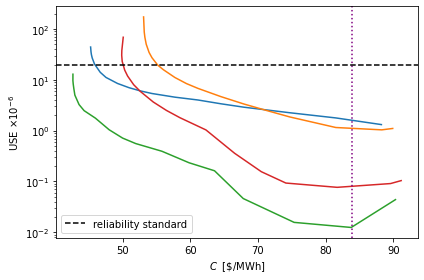

In [64]:
# cost vs USE
plt.plot(df_reliability_cp['cost AUD/MWh'], df_reliability_cp['USE'].values*1000000) #, label='copperplate')
plt.plot(df_reliability_zc['cost AUD/MWh'], df_reliability_zc['USE'].values*1000000) #, label='constrained')
plt.plot(df_reliability_cpb['cost AUD/MWh'], df_reliability_cpb['USE'].values*1000000) #, label='copperplate+battery')
plt.plot(df_reliability_zcb['cost AUD/MWh'], df_reliability_zcb['USE'].values*1000000)#, label='constrained_battery')
# current mix
#plt.scatter(cost23_AUDpMWh, 2, marker='x', color='k', label='current mix')

plt.axvline(x=cost23_AUDpMWh, linestyle=':', color='purple')#, label='cost of current mix')
plt.axhline(y=0.00002*1000000, linestyle='--', color='k', lw=1.5,  label='reliability standard')

plt.xlabel(r"${C}\; $ " +"[\$/MWh]")
plt.ylabel(r"USE $\times 10^{-6}$")

plt.yscale('log')

plt.legend()
plt.tight_layout()


plt.savefig('cost_USE.png', dpi=300)
plt.show()

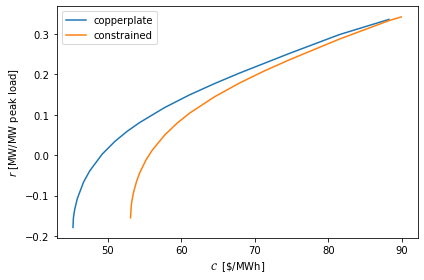

In [65]:
# cost vs mean VRE residual
plt.plot(df_reliability_cp['cost AUD/MWh'], df_res_cp_10y.mean(), label='copperplate')
plt.plot(df_reliability_zc['cost AUD/MWh'], df_res_zc_10y.mean(), label='constrained')
#plt.plot(df_reliability_cpb['cost AUD/MWh'], df_res_cpb.mean(), label='copperplate+battery')
#plt.plot(df_reliability_zcb['cost AUD/MWh'], df_res_zcb.mean(), label='constrained_battery')

plt.xlabel(r"$\mathcal{C}\; $ " +"[\$/MWh]")
plt.ylabel(r"$r$ [MW/MW peak load]")


plt.legend()
plt.tight_layout()
plt.show()

In [66]:
df_zc.loc['gas']

1     0.700128
2     0.714901
3     0.720498
4     0.726817
5     0.733121
6     0.737240
7     0.743646
8     0.746745
9     0.753157
10    0.758633
11    0.763028
12    0.770415
13    0.776969
14    0.782655
15    0.788364
16    0.798284
17    0.808225
18    0.814752
Name: gas, dtype: float64

In [67]:
df_cp.loc['gas']

1     0.553794
2     0.560286
3     0.563155
4     0.567770
5     0.579372
6     0.598873
7     0.612018
8     0.629784
9     0.642828
10    0.653170
11    0.661604
12    0.675239
13    0.686695
14    0.698710
15    0.709855
16    0.730182
17    0.750371
18    0.781360
Name: gas, dtype: float64

In [68]:
df_zc.loc['gas']-df_cp.loc['gas']

1     0.146334
2     0.154615
3     0.157342
4     0.159046
5     0.153749
6     0.138366
7     0.131628
8     0.116961
9     0.110329
10    0.105463
11    0.101425
12    0.095176
13    0.090275
14    0.083945
15    0.078509
16    0.068102
17    0.057854
18    0.033392
Name: gas, dtype: float64

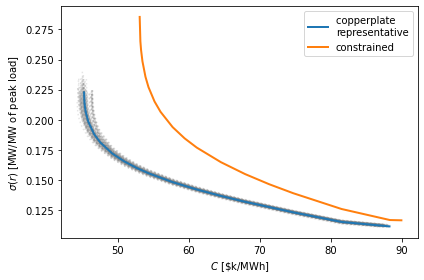

In [69]:
# plot efficient frontier

for bs in range(100):

    plt.plot(EF[bs].iloc[-2]/annual_demand_bs54, np.sqrt(EF[bs].iloc[-1]), linestyle=':', color='grey', alpha=0.2)
    
plt.plot(df_cp.iloc[-2]/annual_demand_bs54, np.sqrt(df_cp.iloc[-1]), lw=2, label='copperplate \nrepresentative')
plt.plot(df_zc.iloc[-2]/annual_demand_bs54, np.sqrt(df_zc.iloc[-1]), lw=2, label='constrained')

plt.xlabel(r"${C} $" +" [\$k/MWh]")
plt.ylabel('$\sigma(r)$ [MW/MW of peak load]')

plt.legend()
plt.tight_layout()

plt.savefig('EF.png', dpi=300)

plt.show()

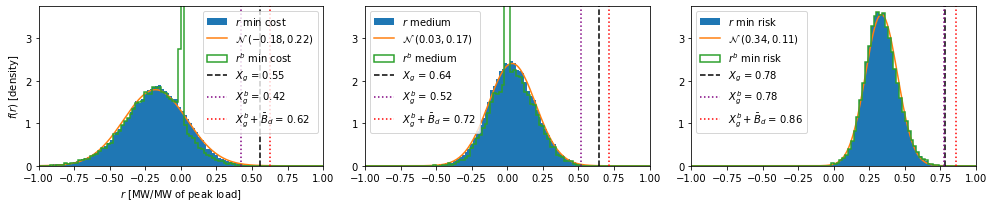

In [70]:
# show the effect of load shifting on the distribution of the residual demand that must be met by gas

fig, ax = plt.subplots(1,3, figsize=(14,3))

l_plot_portfolios=[1, 9, 18]
l_plot_labels=['min cost', 'medium', 'min risk']
bins=np.linspace(-1, 1, 101)
#l_colors=['tab:blue', 'tab:red', 'tab:green']
for i in range(len(l_plot_portfolios)):
    portfolio=l_plot_portfolios[i]
    series=df_res_cp_10y[portfolio]
    # plot histogram
    ax[i].hist(series, bins=bins, density=True, label=r'$r$ '+l_plot_labels[i])
    # plot inferred Gaussian
    x_axis=np.linspace(-1,1, 200)
    #x_axis=np.linspace(-1, 1, 1000)
    _mean=series.mean()
    _std= series.std()
    ax[i].plot(x_axis, stats.norm.pdf(x_axis, _mean, _std), 
               label=r'$\mathcal{N}\;(%0.2f, %0.2f)$' %(np.around(_mean, 2), np.around(_std, 2))) 
   
    
    ax[i].hist(df_res_cpb[portfolio], bins=bins, density=True, histtype='step', lw=1.5, 
               label=r'$r^b$ '+l_plot_labels[i])
    
    # plot installed capacity of gas
    IC_gas=df_cp.loc['gas', portfolio]
    ax[i].axvline(x=IC_gas, color='k', linestyle='--', label='$X_g$ = %0.2f' % IC_gas)
    IC_gas_battery=Xg_cpb[portfolio]
    max_discharge=df_charge_cpb[portfolio].min()*(-1)
    ax[i].axvline(x=IC_gas_battery, color='purple', linestyle=':', label='$X_g^{b}$ = %0.2f' % IC_gas_battery)
    ax[i].axvline(x=IC_gas_battery+max_discharge, color='r', linestyle=':', label=r'$X_g^{b}+\bar{B}_d$ = %0.2f' 
                  % (IC_gas_battery+max_discharge))

    
    
    
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(0, 3.75)
    
    #ax[i].set_yscale('log')
    
    ax[i].legend()
    
    if i==0:
        ax[i].set_ylabel('$f(r)$ [density]')
        ax[i].set_xlabel(r'$r$ [MW/MW of peak load]')
    
    #if i!=0:
    #    ax[i].set_yticks([])
plt.tight_layout()

plt.savefig('res_distribution.png', dpi=300)

plt.show()

### analysis -- residuals

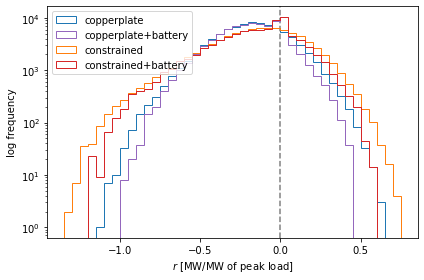

In [71]:
# in histogram

x=np.linspace(-1.35, 0.75, 43)
plt.axvline(0, color='grey', linestyle='--')

plt.hist(df_res_cp_10y[1], bins=x, histtype='step', color='tab:blue', label='copperplate')
plt.hist(df_res_cpb[1], bins=x, histtype='step', color='tab:purple', label='copperplate+battery')
plt.hist(df_res_zc_10y[1], bins=x, histtype='step', color='tab:orange', label='constrained')
plt.hist(df_res_zcb[1], bins=x, histtype='step', color='tab:red', label='constrained+battery')

plt.yscale('log')

plt.legend(loc='upper left')
plt.ylabel('log frequency')
plt.xlabel('$r$ [MW/MW of peak load]')
plt.tight_layout()

#plt.savefig('dist_residuals_mincost.png', dpi=300)
plt.show()




## maps

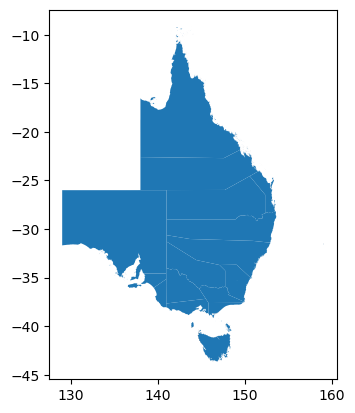

In [72]:
import matplotlib
# load NEM base map
zones=[col.split('_')[0] for col in df_VRE.columns[:16]]
with open( '../raw_data/NEM_map/gdf_nem_zones.pickle', 'rb') as f:
    gdf_nem_zones=pickle.load(f)

# reorder nem zones to match with the tables    
gdf_nem_zones=gdf_nem_zones.reindex(zones)
    
# check plot 
matplotlib.rc_file_defaults()
ax = gdf_nem_zones.plot()
plt.show()

In [73]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [74]:
wind_norm = mpl.colors.Normalize(vmin=0,  vmax=1)  
cmap_wind = mpl.cm.ScalarMappable(norm=wind_norm, cmap=truncate_colormap(mpl.cm.Blues, minval=0.1))

solar_norm = mpl.colors.Normalize(vmin=0,  vmax=1)  
cmap_solar = mpl.cm.ScalarMappable(norm=solar_norm, cmap=truncate_colormap(mpl.cm.Oranges, minval=0.1))

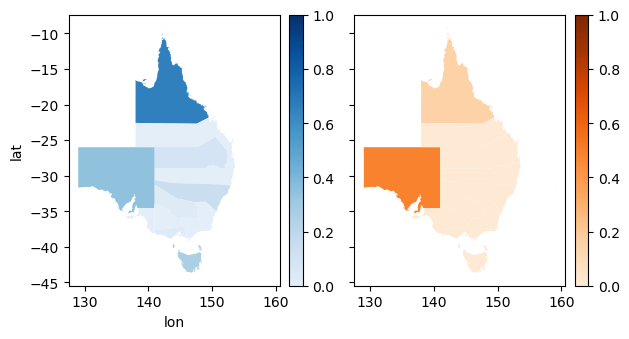

In [75]:
# copperplate min cost
fig, (ax1, ax2) = plt.subplots(ncols=2,  sharex=True, sharey=True)

im1=gdf_nem_zones.plot(ax=ax1, color=[cmap_wind.to_rgba(x) for x in df_cp[1][:16].values])
plt.colorbar(cmap_wind, ax=ax1, fraction=0.058, pad=0.04)
im1.set_xlabel('lon')
im1.set_ylabel('lat')

im2=gdf_nem_zones.plot(ax=ax2, color=[cmap_solar.to_rgba(x) for x in df_cp[1][16:32].values])
plt.colorbar(cmap_solar, ax=ax2, fraction=0.058, pad=0.04)


fig.tight_layout()
fig.savefig('map_cp_mincost.png', dpi=300)

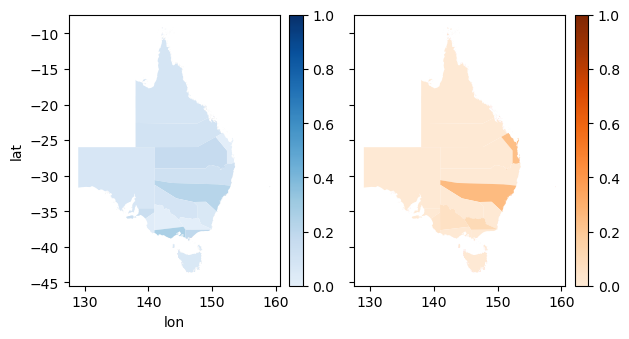

In [76]:
# constrained min cost 

fig, (ax1, ax2) = plt.subplots(ncols=2,  sharex=True, sharey=True)

im1=gdf_nem_zones.plot(ax=ax1, color=[cmap_wind.to_rgba(x) for x in df_zc[1][:16].values])
plt.colorbar(cmap_wind, ax=ax1, fraction=0.058, pad=0.04)

im2=gdf_nem_zones.plot(ax=ax2, color=[cmap_solar.to_rgba(x) for x in df_zc[1][16:32].values])
plt.colorbar(cmap_solar, ax=ax2, fraction=0.058, pad=0.04)

im1.set_xlabel('lon')
im1.set_ylabel('lat')


fig.tight_layout()
fig.savefig('map_zc_mincost.png', dpi=300)


### vs output maximisation


In [77]:
mean_VRE=df_VRE.mean()

df_VRE.head()

df_VRE.mean().sort_values()

# hour by hour covariance
df_VRE_hourly=df_VRE.pivot_table(df_VRE.columns, df_VRE.index.date, df_VRE.index.hour).reindex(
    columns=df_VRE.columns, level=0)
df_VRE_hourly

tilde_cov=np.zeros((32,32))
M_VRE_hourly_cov=df_VRE_hourly.cov().values

for i in range(32):
    for j in range(i,32):
        _M=M_VRE_hourly_cov[i*24:(i+1)*24, j*24:(j+1)*24]
        if i==j:
            tilde_cov[i,j]=_M.sum()
        else:
            tilde_cov[i,j]=_M.sum()
            tilde_cov[j,i]=_M.sum()
tilde_cov=tilde_cov/(24**2)
tilde_cov

# output maximisation --- trivial, TAS wind

# output variablility risk minimisation

from qpsolvers import Problem, solve_problem
from scipy import sparse


problem_minrisk_output = Problem(P=tilde_cov, q=np.zeros(32), G=None,  A=np.ones(32), b=np.array([1]),
                              lb=np.zeros(32), ub=np.repeat(1, 32))                         
# quadprog is the best solver here
solution_minrisk_output = solve_problem(problem_minrisk_output, solver='quadprog', verbose=True)

print('optimal = ', solution_minrisk_output.is_optimal(1e-8))
print('objective =', solution_minrisk_output.obj)

minrisk_output_portfolio=pd.Series(index=df_VRE.columns, data=solution_minrisk_output.x)
minrisk_output_portfolio[minrisk_output_portfolio<0.000001]=0
minrisk_output_portfolio


minrisk_output_portfolio.sum()

minrisk_output=np.dot(mean_VRE.values, minrisk_output_portfolio.values)
minrisk_output

# max output, with constraints

# load constraints

file1 = open('../model/constrained/compute_constraints/Aub_zonal.pkl', 'rb')

Aub_zonal = pickle.load(file1)

file1.close()

file2 = open('../model/constrained/compute_constraints/bub_zonal.pkl', 'rb')

bub_zonal = pickle.load(file2)

file2.close()

file3 = open('../model/constrained/compute_constraints/lb_zones.pkl', 'rb')

lb_zones = pickle.load(file3)

file3.close()

print(Aub_zonal.shape, bub_zonal.shape, lb_zones)




from scipy.optimize import linprog

# objective
c=-mean_VRE.values

lb=np.zeros(32)
ub=np.ones(32)
bounds=[(lb[i], ub[i]) for i in range(len(lb))]

soln_maxout_constrained = linprog(c, A_eq=np.ones(32).reshape(1,-1), b_eq=np.array([1]), A_ub=Aub_zonal, b_ub=bub_zonal, 
              bounds=bounds, method='highs-ipm')

print((-1)*(soln_maxout_constrained.fun))

maxout_constrained=pd.Series(index=df_VRE.columns, data=soln_maxout_constrained.x)
maxout_constrained[maxout_constrained<0.000001]=0
maxout_constrained





maxout_constrained.sum()

optimal =  True
objective = 0.0003363935490325134
(21, 32) (21,) ['ADE', 'SEQ', 'NCEN', 'MEL', 'TAS']
0.46394792591833883


1.0

In [78]:
max_output_constrained=np.dot(mean_VRE.values, maxout_constrained.values)
max_output_constrained

problem_minrisk_output_constrained = Problem(P=tilde_cov, q=np.zeros(32), G=Aub_zonal, h=bub_zonal,
                                             A=np.ones(32), b=np.array([1]), lb=np.zeros(32), ub=np.repeat(1, 32))                         
# quadprog is the best solver here
solution_minrisk_output_constrained = solve_problem(problem_minrisk_output_constrained, solver='quadprog', 
                                                    verbose=True)

print('optimal = ', solution_minrisk_output_constrained.is_optimal(1e-8))
print('objective =', solution_minrisk_output_constrained.obj)

minrisk_output_constrained=pd.Series(index=df_VRE.columns, data=solution_minrisk_output_constrained.x)
minrisk_output_constrained[minrisk_output_constrained<0.000001]=0
minrisk_output_constrained


minrisk_output_constrained.sum()

optimal =  True
objective = 0.0005801057291340108


0.9999999999999999

In [79]:
minrisk_constrained_output=np.dot(mean_VRE.values, minrisk_output_constrained.values)
minrisk_constrained_output

0.2451551524480695

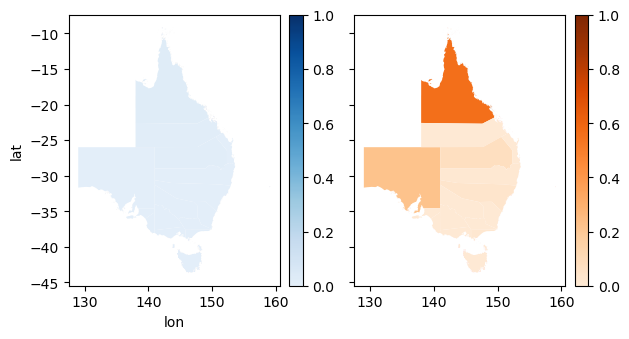

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2,  sharex=True, sharey=True)

im1=gdf_nem_zones.plot(ax=ax1, color=[cmap_wind.to_rgba(x) for x in minrisk_output_portfolio[:16].values])
plt.colorbar(cmap_wind, ax=ax1, fraction=0.058, pad=0.04)

im2=gdf_nem_zones.plot(ax=ax2, color=[cmap_solar.to_rgba(x) for x in minrisk_output_portfolio[16:32].values])
plt.colorbar(cmap_solar, ax=ax2, fraction=0.058, pad=0.04)
im1.set_xlabel('lon')
im1.set_ylabel('lat')



fig.tight_layout()
fig.savefig('map_cp_output_minrisk.png', dpi=300)

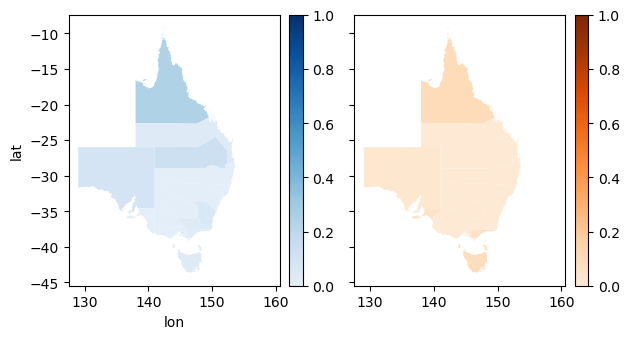

In [81]:
fig, (ax1, ax2) = plt.subplots(ncols=2,  sharex=True, sharey=True)

im1=gdf_nem_zones.plot(ax=ax1, color=[cmap_wind.to_rgba(x) for x in df_cp[18][:16].values])
plt.colorbar(cmap_wind, ax=ax1, fraction=0.058, pad=0.04)

im2=gdf_nem_zones.plot(ax=ax2, color=[cmap_solar.to_rgba(x) for x in df_cp[18][16:32].values])
plt.colorbar(cmap_solar, ax=ax2, fraction=0.058, pad=0.04)

im1.set_xlabel('lon')
im1.set_ylabel('lat')


fig.tight_layout()
fig.savefig('map_cp_minrisk.png', dpi=300)